In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.style.use('seaborn')

#setting matplotlib parameters
params = {'axes.titlesize':'20',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
         'axes.labelsize': '14',
         'legend.fontsize': '14'}
mpl.rcParams.update(params)

# I. Importing Data

In [2]:
semester_names = ['spring', 'summer', 'fall']
dow_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

c = pd.read_csv('../Data/crime_data_clean.csv', index_col='time', parse_dates=True)

#setting semester as categorical datatype to maintain correct order
c['semester'] = c['semester'].astype(pd.api.types.CategoricalDtype(
    categories = semester_names, ordered=True))

c.head()

,code,description,disposition,location,patrol_zone,landmark,lat,long,year,month,...,inc_15_25,inc_25_35,inc_35_50,inc_50_75,inc_75_100,inc_100_150,inc_150_200,inc_greater_200,inc_median,inc_mean
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:36:00,7399,Miscellaneous Offenses,NaN,NONCAM,Z4,NaN,33.773124,-84.403163,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 01:55:00,7399,Miscellaneous Offenses,NaN,ONCAMRES,Z1,Center Street Apartments North,0.000000,0.000000,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 02:00:00,2308,Larceny - From Building,NaN,NONCAM,Z2,Sigma Nu Fraternity,33.775556,-84.394180,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 12:00:00,2204,Burglary - No Forced Entry - Residence,Unfounded,ONCAMRES,Z2,North Avenue Apartments North Building,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-02 06:15:00,7399,Miscellaneous Offenses,NaN,ONCAM,Z2,North Avenue Apartments,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299


# II. Feature Engineering

In [3]:
non_features = ['code', 'lat', 'long', 'day_of_year', 'day_of_month', 'day_of_week', 'hour']
f = c.groupby(['year', 'month']).mean().drop(columns=non_features)
f['num_crimes'] = c.groupby(['year', 'month']).size()

for month in range(1, 13):
    f['past_num_crimes_{}'.format(month)] = f['num_crimes'].shift(month)

f = f.reset_index()

f['is_before_2012_fall'] = (f['year']<=2011) | ((f['year']==2012)&(f['month']<=7))
f['is_before_2012_fall'] = f['is_before_2012_fall'].astype(int)

f.head()

,year,month,enrollment,pop_total,pop_male,pop_female,pop_under_5,pop_5_9,pop_10_14,pop_15_19,...,past_num_crimes_4,past_num_crimes_5,past_num_crimes_6,past_num_crimes_7,past_num_crimes_8,past_num_crimes_9,past_num_crimes_10,past_num_crimes_11,past_num_crimes_12,is_before_2012_fall
0,2010,1,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2010,2,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2010,3,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2010,4,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2010,5,10831.23301,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
def day_counter(yr, day_of_week):
    """Calculates counts of a given day of the week in each month for a given year
    yr: integer of a year to find counts of
    day_of_week: name of the day of week to find counts of
    returns DataFrame with a column of the count for the day indexed by year, month"""
    
    day_counts = np.zeros(12)
    date = datetime.date(yr, 1, 1)
    
    while date.year == yr:
        month = date.month
        weekday = date.weekday()
        if weekday == day_of_week:
            day_counts[month-1] += 1
        date = date + datetime.timedelta(days=1)
    
    counts_dict = {'year': [yr for i in range(12)],
                   'month': [i for i in range(1, 13)],
                   'count': day_counts}
    counts_df = pd.DataFrame(counts_dict).set_index(['year', 'month'])
    
    return counts_df

sunday_counts = [day_counter(yr, 6) for yr in range(2010, 2018)] + [day_counter(2018, 6).iloc[:4]]
sunday_counts = pd.concat(sunday_counts).reset_index(drop=True)
f['num_sundays'] = sunday_counts
f['num_sundays'].head()

0    5.0
1    4.0
2    4.0
3    4.0
4    5.0
Name: num_sundays, dtype: float64

In [5]:
month_dummies = pd.get_dummies(f['month'], prefix='is_month', drop_first=True)
f[month_dummies.columns] = month_dummies

f[month_dummies.columns].head()

,is_month_2,is_month_3,is_month_4,is_month_5,is_month_6,is_month_7,is_month_8,is_month_9,is_month_10,is_month_11,is_month_12
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [6]:
prop_df = c.groupby(['month', 'day_of_week']).size().unstack()
prop_df = prop_df.div(prop_df.sum(axis='columns'), axis='rows')
prop_df.columns = ['prop_' + name for name in dow_names]

f = f.merge(prop_df[['prop_sunday']],
            left_on='month', right_index=True, how='left')
prop_df.head()

,prop_monday,prop_tuesday,prop_wednesday,prop_thursday,prop_friday,prop_saturday,prop_sunday
month,,,,,,,
1,0.132004,0.137702,0.131054,0.124406,0.155745,0.169041,0.150047
2,0.129170,0.122327,0.134303,0.139435,0.187340,0.164243,0.123182
3,0.115833,0.138333,0.152500,0.155000,0.170833,0.160833,0.106667
4,0.130961,0.135503,0.119606,0.143073,0.189251,0.152914,0.128690
5,0.114194,0.146211,0.132337,0.157951,0.184632,0.160085,0.104589


In [7]:
pop_df = c[['year', 'pop_total', 'pop_15_19']].drop_duplicates().set_index('year')
pop_df['prop_15_19'] = pop_df['pop_15_19'].div(pop_df['pop_total'])

f = f.merge(pop_df[['prop_15_19']],
            left_on='year', right_index=True, how='left')

pop_df.head()

,pop_total,pop_15_19,prop_15_19
year,,,
2010,413462,30806,0.074507
2011,419250,30602,0.072992
2012,425931,29980,0.070387
2013,432589,29556,0.068324
2014,440641,29071,0.065974


In [8]:
f = f.set_index(['year', 'month'])
f.tail(12)

enrollment  pop_total  pop_male  pop_female  pop_under_5  \
year month                                                               
2017 8      27367.803279   463855.0  229305.0    234550.0      26813.0   
     9      29369.000000   463855.0  229305.0    234550.0      26813.0   
     10     29369.000000   463855.0  229305.0    234550.0      26813.0   
     11     29369.000000   463855.0  229305.0    234550.0      26813.0   
     12     29369.000000   463855.0  229305.0    234550.0      26813.0   
2018 1      28437.000000   471332.0  233407.0    237925.0      26519.0   
     2      28437.000000   471332.0  233407.0    237925.0      26519.0   
     3      28437.000000   471332.0  233407.0    237925.0      26519.0   
     4      28437.000000   471332.0  233407.0    237925.0      26519.0   
     5      17760.840000   471332.0  233407.0    237925.0      26519.0   
     6      13609.000000   471332.0  233407.0    237925.0      26519.0   
     7      13609.000000   471332.0  233407.0    237925.0      26519.0   

            pop_5_9  pop_10_14  pop_15_19  pop_20_24  pop_25_34     ...      \
year month                                                          ...       
2017 8      25046.0    23551.0    29764.0    44330.0    94749.0     ...       
     9      25046.0    23551.0    29764.0    44330.0    94749.0     ...       
     10     25046.0    23551.0    29764.0    44330.0    94749.0     ...       
     11     25046.0    23551.0    29764.0    44330.0    94749.0     ...       
     12     25046.0    23551.0    29764.0    44330.0    94749.0     ...       
2018 1      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     2      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     3      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     4      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     5      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     6      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     7      26187.0    24008.0    30220.0    43205.0    97284.0     ...       

            is_month_5  is_month_6  is_month_7  is_month_8  is_month_9  \
year month                                                               
2017 8               0           0           0           1           0   
     9               0           0           0           0           1   
     10              0           0           0           0           0   
     11              0           0           0           0           0   
     12              0           0           0           0           0   
2018 1               0           0           0           0           0   
     2               0           0           0           0           0   
     3               0           0           0           0           0   
     4               0           0           0           0           0   
     5               1           0           0           0           0   
     6               0           1           0           0           0   
     7               0           0           1           0           0   

            is_month_10  is_month_11  is_month_12  prop_sunday  prop_15_19  
year month                                                                  
2017 8                0            0            0     0.122760    0.064167  
     9                0            0            0     0.091238    0.064167  
     10               1            0            0     0.116321    0.064167  
     11               0            1            0     0.102564    0.064167  
     12               0            0            1     0.071325    0.064167  
2018 1                0            0            0     0.150047    0.064116  
     2                0            0            0     0.123182    0.064116  
     3                0            0            0     0.106667    0.064116  
     4                0            0            0     0.128690 

In [9]:
f.describe()

,enrollment,pop_total,pop_male,pop_female,pop_under_5,pop_5_9,pop_10_14,pop_15_19,pop_20_24,pop_25_34,...,is_month_5,is_month_6,is_month_7,is_month_8,is_month_9,is_month_10,is_month_11,is_month_12,prop_sunday,prop_15_19
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.000000,103.000000,103.000000,103.00000,103.00000,103.00000,103.00000,103.00000,103.000000,103.000000
mean,19679.651743,439916.582524,217811.194175,222105.388350,27043.621359,23146.572816,21710.291262,29774.834951,44347.097087,87078.873786,...,0.087379,0.087379,0.087379,0.07767,0.07767,0.07767,0.07767,0.07767,0.112968,0.067834
std,5873.430267,18398.278225,8603.065411,9816.955794,424.332142,1242.592298,1430.247542,643.350179,1741.362660,5859.248481,...,0.283770,0.283770,0.283770,0.26896,0.26896,0.26896,0.26896,0.26896,0.018835,0.003890
min,8822.000000,413462.000000,205715.000000,207747.000000,26519.000000,22114.000000,19818.000000,28852.000000,41124.000000,77791.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.071325,0.064116
25%,16378.187241,425931.000000,211553.000000,214378.000000,26713.000000,22332.000000,20451.000000,29308.000000,43205.000000,83167.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.104589,0.064219
50%,20589.384615,440641.000000,217938.000000,222703.000000,26903.000000,22606.000000,21576.000000,29764.000000,44330.000000,86918.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.116321,0.065974
75%,23855.208333,456378.000000,225203.000000,231175.000000,27123.000000,23905.000000,23094.000000,30220.000000,45455.000000,92214.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.123182,0.070387
max,29369.000000,471332.000000,233407.000000,237925.000000,27976.000000,26187.000000,24008.000000,30806.000000,46580.000000,97284.000000,...,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,0.150047,0.074507


# III. Regression

Now that we have the data in a form we can work with, it's time to try to fit a regression model to our data.

### A. Preliminary Work

In [10]:
#imports
import itertools
from statsmodels.tsa.ar_model import AR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

D:\Miniconda2\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
#creating several functions to simplify plotting results for various models

def plot_fit(y_obs, y_pred, ax, intervals=False):
    data = ax.scatter(x=range(len(y_obs)), y=y_obs, c='b')
    ax.plot(y_pred, c='k')
    ax.set_title('Regression')
    ax.set_ylabel('Number of Crimes')
    ax.set_xticks(range(0, len(y_obs)+6, 12))
    ax.set_xticklabels(range(2010, 2019))
    if intervals:
        ax.set_title('Regression with 95% Prediction Interval')
        mse = mean_squared_error(y_obs, y_pred)
        y_upper = y_pred + 1.96*np.sqrt(mse)
        y_lower = y_pred - 1.96*np.sqrt(mse)
        size = len(y_obs)
        ax.fill(list(range(size)) + list(range(size-1, -1, -1)),
                   np.concatenate((y_upper, y_lower[::-1])), alpha=0.2, color='k')
    return ax

def plot_residuals(y_obs, y_pred, ax, standardized=True):
    residuals = y_obs - y_pred
    size = len(residuals)
    if standardized:
        residuals = (residuals - np.mean(residuals))/np.std(residuals)
    data = ax.scatter(x=range(size), y=residuals, c='b')
    ax.set_xticks(range(0, size+6, 12))
    ax.set_xticklabels(range(2010, 2019))
    ax.set_xlim(-3, size+3)
    ax.set_ylim(-3.9, 3.9)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_title('Residuals Plot')
    ax.set_ylabel('Standardized Residuals')
    return ax

def plot_observed_predicted(y_obs, y_pred, ax):
    data = ax.scatter(x=y_obs, y=y_pred, c='b')
    vals = np.concatenate((y_obs, y_pred))
    lower = np.min(vals) - 5
    upper = np.max(vals) + 5
    ax.plot([lower, upper], [lower, upper], color='k', alpha=0.5, linestyle='--')
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    ax.set_title('Observed vs Predicted Plot')
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values - autoregression')
    return ax

def plot_qq(y_obs, y_pred, ax):
    residuals = np.sort(y_obs - y_pred)
    size = len(residuals)
    percentiles = np.linspace(1/(size+1), 1, size, endpoint=False)
    x = stats.norm.ppf(percentiles)
    y = (residuals - np.mean(residuals))/np.std(residuals)
    ax.scatter(x=x, y=y)
    ax.plot([-3, 3], [-3, 3], color='k', alpha=0.5, linestyle='--')
    ax.set_title('QQ Plot')
    ax.set_xlabel('Theoretical Normal Quantiles')
    ax.set_ylabel('Observed Residual Quantiles')
    return ax
    
def plot_summary(y_obs, y_pred, title=None, standardized=True, intervals=False):
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax = [ax1, ax2, ax3, ax4]
    plot_fit(y_obs, y_pred, ax[0], intervals)
    plot_residuals(y_obs, y_pred, ax[1], standardized)
    plot_observed_predicted(y_obs, y_pred, ax[2])
    plot_qq(y_obs, y_pred, ax[3])
    #plt.tight_layout()
    if title:
        plt.suptitle(title, fontsize=20)
    return ax

def summary_statistics(y_obs, y_pred, n):
    residuals = y_obs - y_pred
    mean = np.mean(y_obs)
    ss_r = np.square(residuals).sum()
    ss_t = np.square((y_obs - mean)).sum()
    r_squared = 1 - ss_r/ss_t
    mse = ss_r/len(y_obs)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_obs)-1)/(len(y_obs)-n-1)
    print('MSE: {0:.{1}f}'.format(mse, 4))
    print('RMSE: {0:.{1}f}'.format(np.sqrt(mse), 4))
    print('R-squared: {0:.{1}f}'.format(r_squared, 4))
    print('Adjusted R-squared: {0:.{1}f}'.format(adjusted_r_squared, 4))
    return mse, r_squared, adjusted_r_squared

Let's split our data into training and test sets, and plot the results.

We can use 2010-2015 as training data, and 2016-2018 as test data.

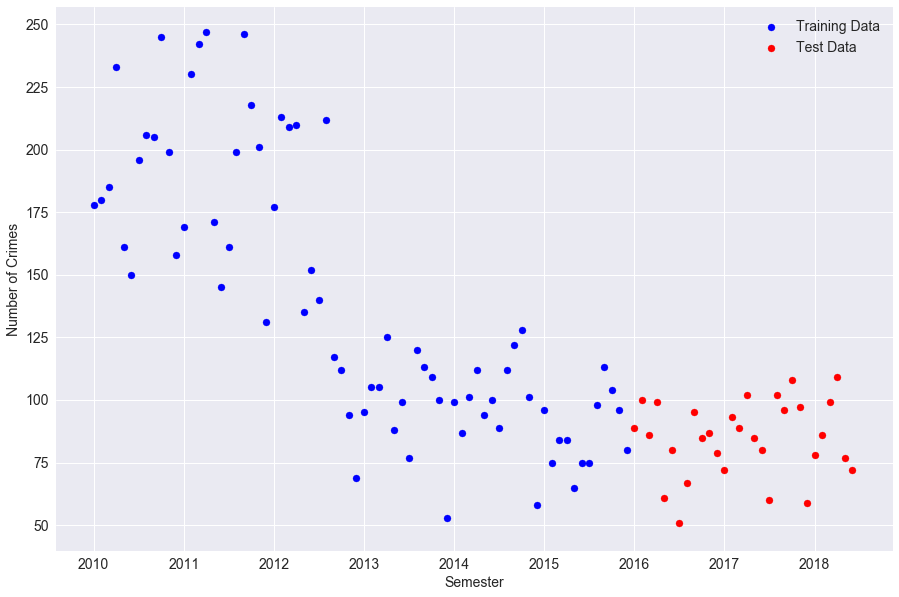

In [12]:
#extracting data
X = f.drop(columns='num_crimes').iloc[:-1]
y = f['num_crimes'].iloc[:-1].values

#splitting into training and test data
X_train = X[:72].values
y_train = y[:72]
X_test = X[72:].values
y_test = y[72:]

#plotting
plt.figure(figsize=(15, 10))
plt.scatter(x = range(len(y_train)), y = y_train, color='b')
plt.scatter(x = range(len(y_train), len(y_train)+len(y_test)), y = y_test, color='r')
plt.xlabel('Semester')
plt.ylabel('Number of Crimes')
plt.legend(['Training Data', 'Test Data'])
plt.xticks(range(0, len(y_train)+len(y_test), 12), range(2010, 2019))
plt.show()

### B. Fitting a Linear Regression and Testing Model Assumptions

We will start by creating a pipeline for our preliminary linear model and fitting it to the training data.

MSE: 223.6968
RMSE: 14.9565
R-squared: 0.9234
Adjusted R-squared: 0.6374


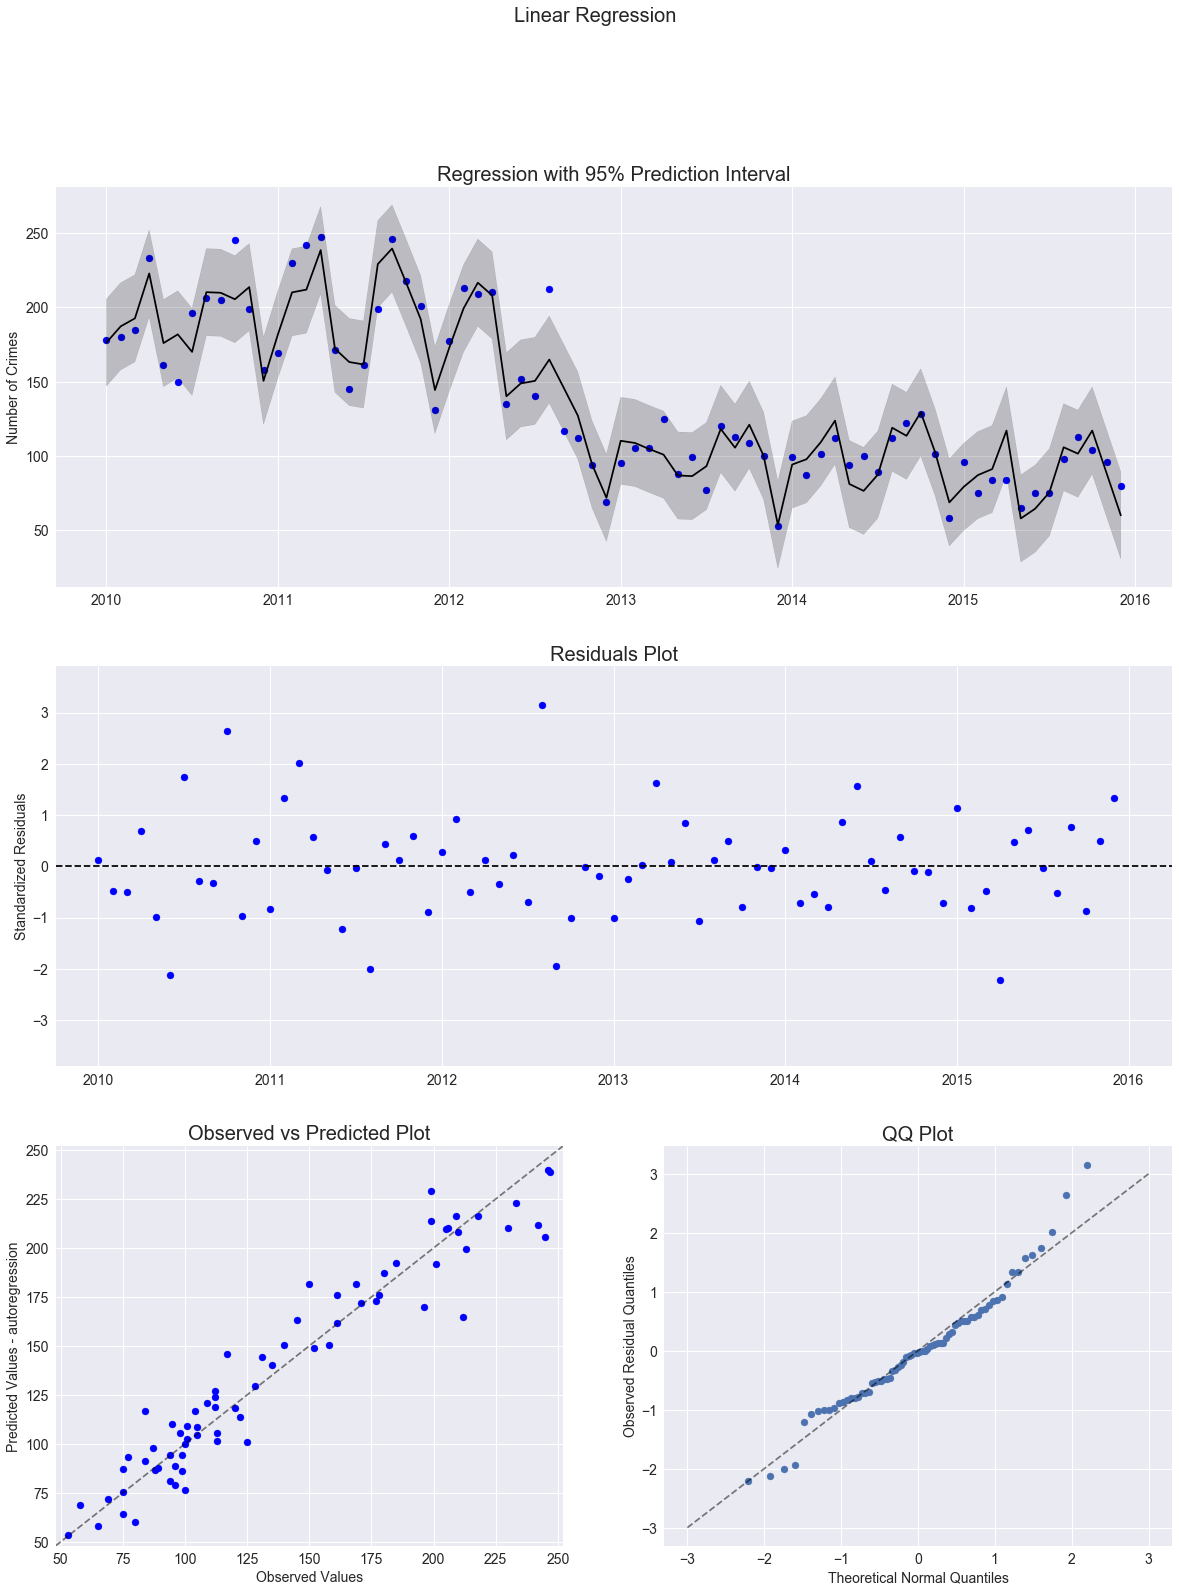

In [13]:
#creating up transformations for pipelines
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
scale = StandardScaler()

#training linear regression
clf_lr = LinearRegression()
steps_lr = [('imputation', imp), ('scale', scale), ('regression', clf_lr)]
pipeline_lr = Pipeline(steps_lr)
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_train)


#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_lr, len(X_train[0]))
plot_summary(y_train, y_pred_lr, 'Linear Regression', intervals=True);

First, let's look at the top chart. The model appears to fit the data very well. The model captures the general decrease in crime throughout the years as well as the periodicity of the months throughout individual years. The residuals plot does not exhibit heteroscedasticity, and the QQ plot is close enough that we can assume normally distributed residuals. The observed vs predicted plot shows us that the model tends to predict equally well across all ranges of values. Overall the model seems like a great fit for the data. The summary statistics are as follows:

MSE: 223.6968

RMSE: 14.9565

R-squared: 0.9234

Adjusted R-squared: 0.6374

We will want to do some feature selection to increase the adjusted R-squared value.

### C. Feature Selection

In [14]:
#determining weak and strong predictor variables
coefs = {col: coef for col, coef in zip(f.drop(columns='num_crimes').columns, clf_lr.coef_)}
coefs = pd.Series(coefs)

print('Strongest predictors:   abs(coefficent)')
np.abs(coefs).sort_values(ascending=False).head()

Strongest predictors:   abs(coefficent)


is_before_2012_fall    28.158337
past_num_crimes_8      18.160879
past_num_crimes_1      10.870860
is_month_4              9.705548
past_num_crimes_3       9.083817
dtype: float64

MSE: 233.8251
RMSE: 15.2913
R-squared: 0.9199
Adjusted R-squared: 0.8863


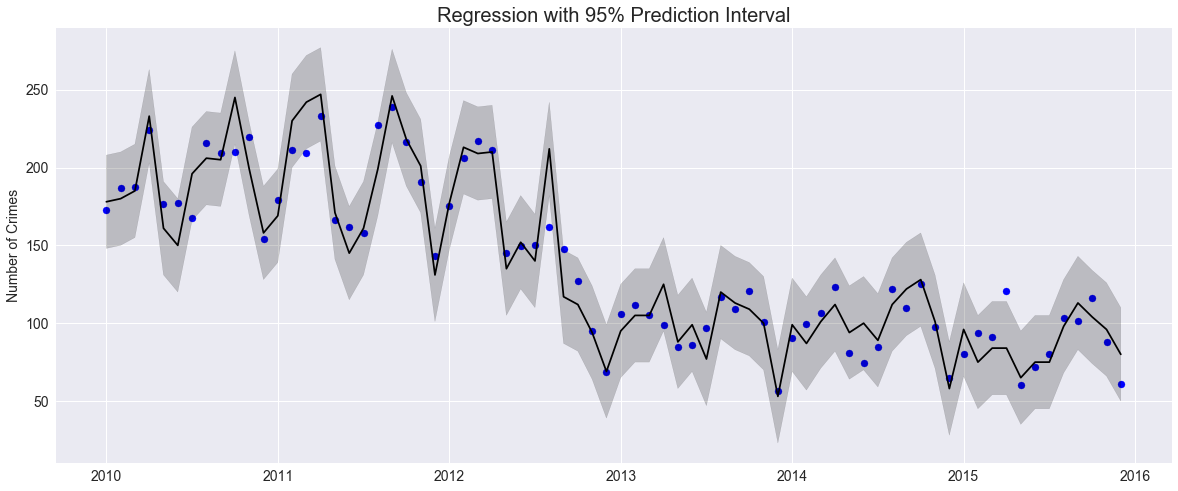

In [15]:
#dropping features with weakest prediction value to maximimize adjusted R-squared
weak_corrs = list(coefs[np.abs(coefs)<1.6].index)

#recreating feature matrix
X = f.drop(columns=weak_corrs + ['num_crimes'] ).iloc[:-1]
X_train = X[:72].values
X_test = X[72:].values

#refitting
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_train)

#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
summary_statistics(y_train, y_pred_lr, len(X_train[0]))
plot_fit(y_pred_lr, y_train, ax, intervals=True);

### D. Training Other Models

MSE: 429.3891
RMSE: 20.7217
R-squared: 0.8530
Adjusted R-squared: 0.7912


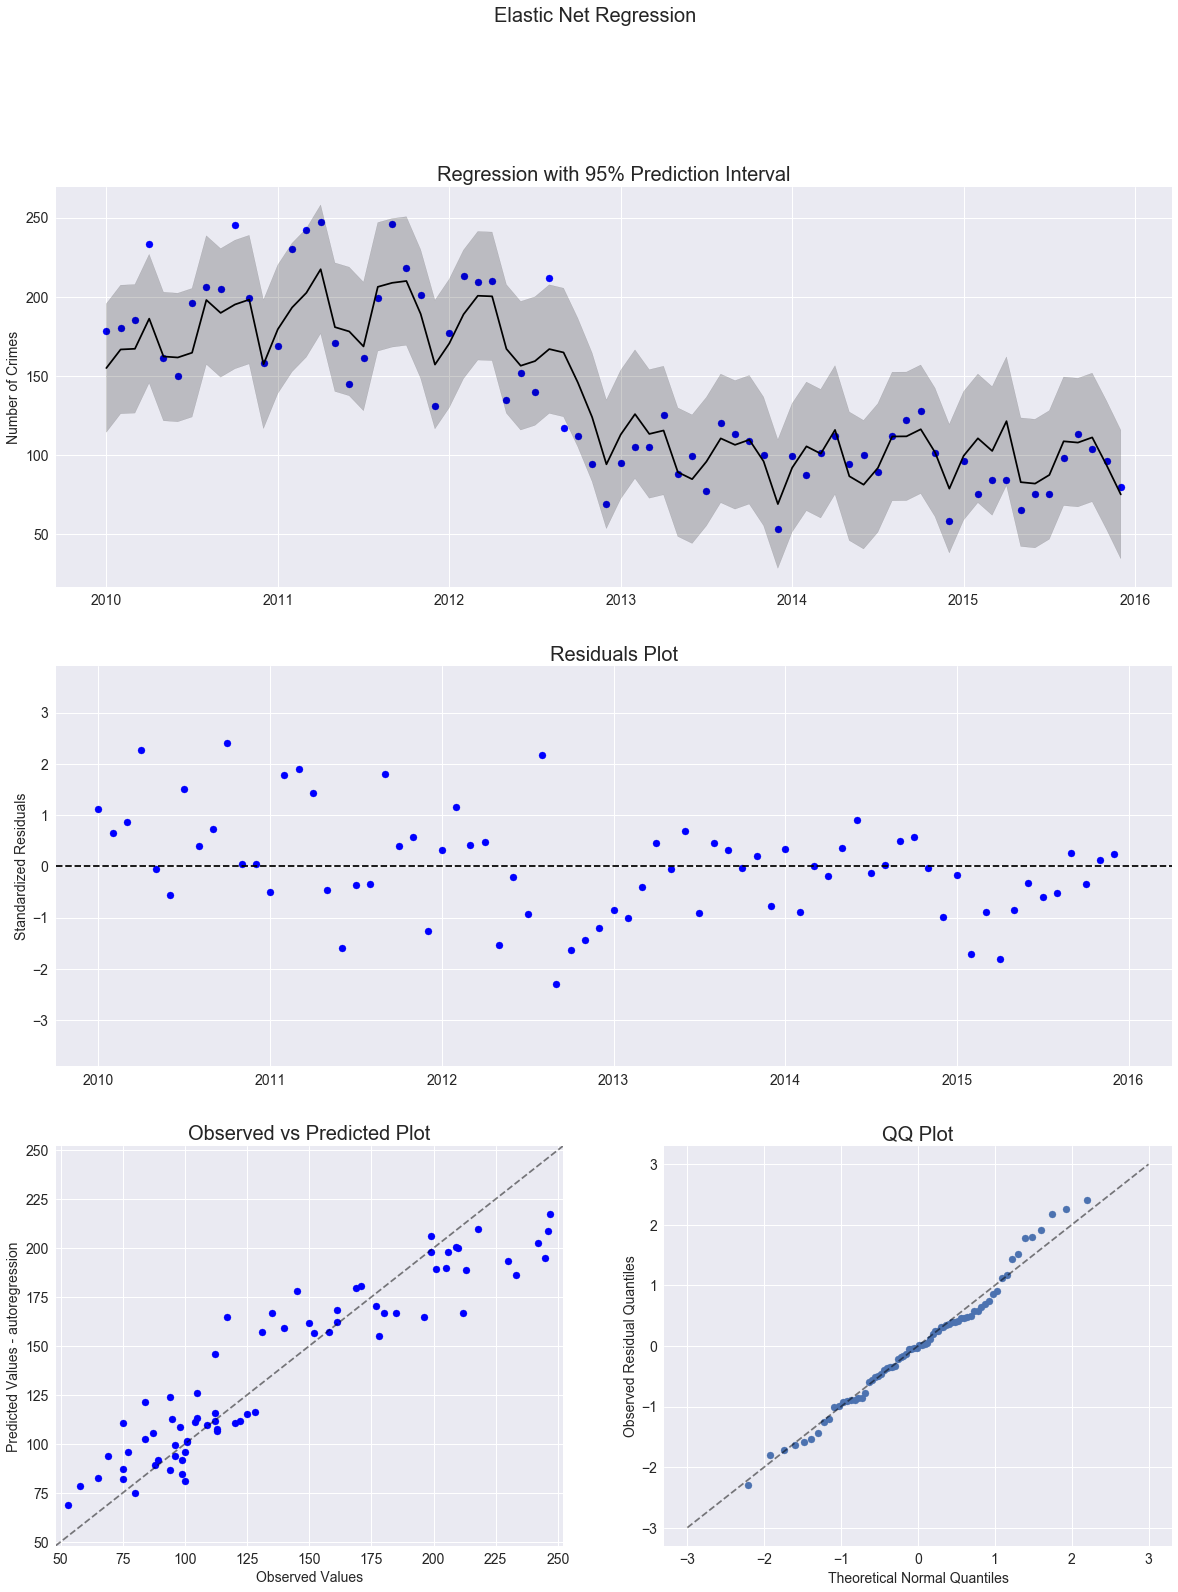

In [17]:
#training elastic net regression
clf_en = ElasticNet()
steps_en = [('imputation', imp), ('scale', scale), ('regression', clf_en)]
pipeline_en = Pipeline(steps_en)
pipeline_en.fit(X_train, y_train)
y_pred_en = pipeline_en.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_en, len(X_train[0]))
plot_summary(y_train, y_pred_en, 'Elastic Net Regression', intervals=True);

MSE: 367.9939
RMSE: 19.1832
R-squared: 0.8740
Adjusted R-squared: 0.8211


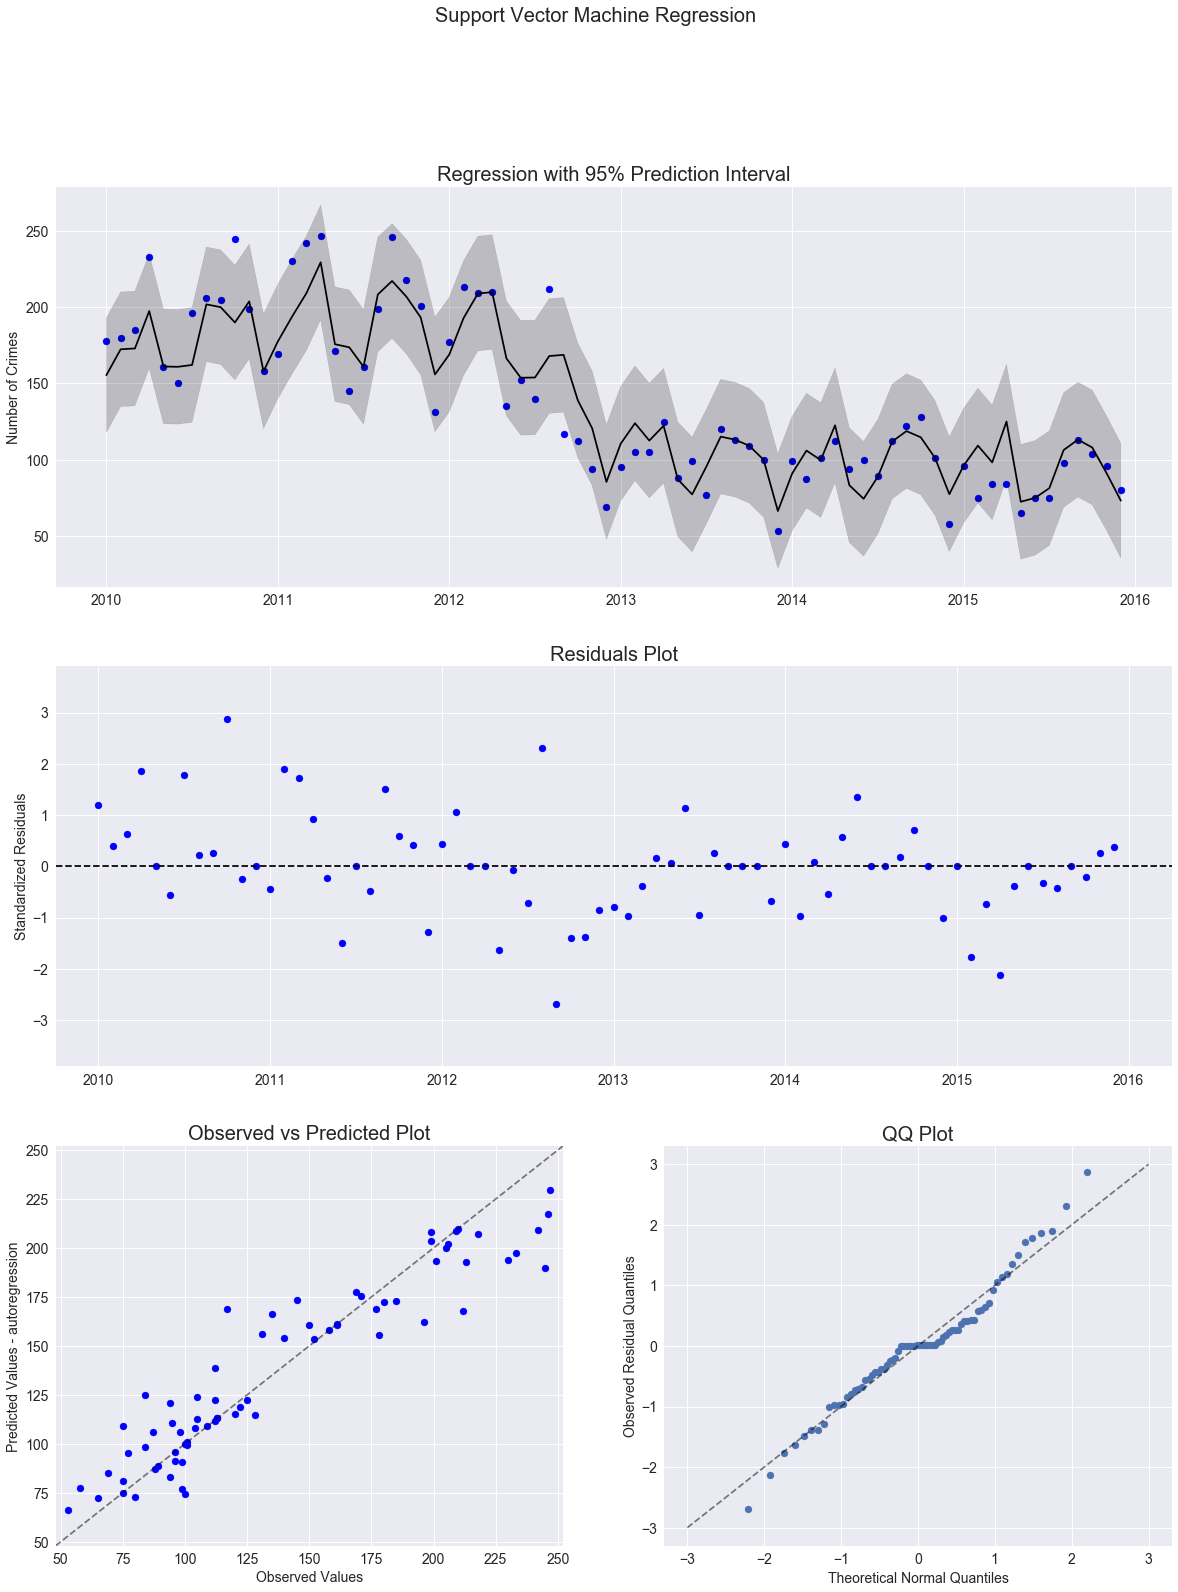

In [18]:
#training svm regression
steps_svr = [('imputation', imp), ('scale', scale),
             ('regression', SVR(kernel='linear'))]
pipeline_svr = Pipeline(steps_svr)
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_svr, len(X_train[0]))
plot_summary(y_train, y_pred_svr, 'Support Vector Machine Regression', intervals=True);

MSE: 367.9939
RMSE: 19.1832
R-squared: 0.8740
Adjusted R-squared: 0.8211


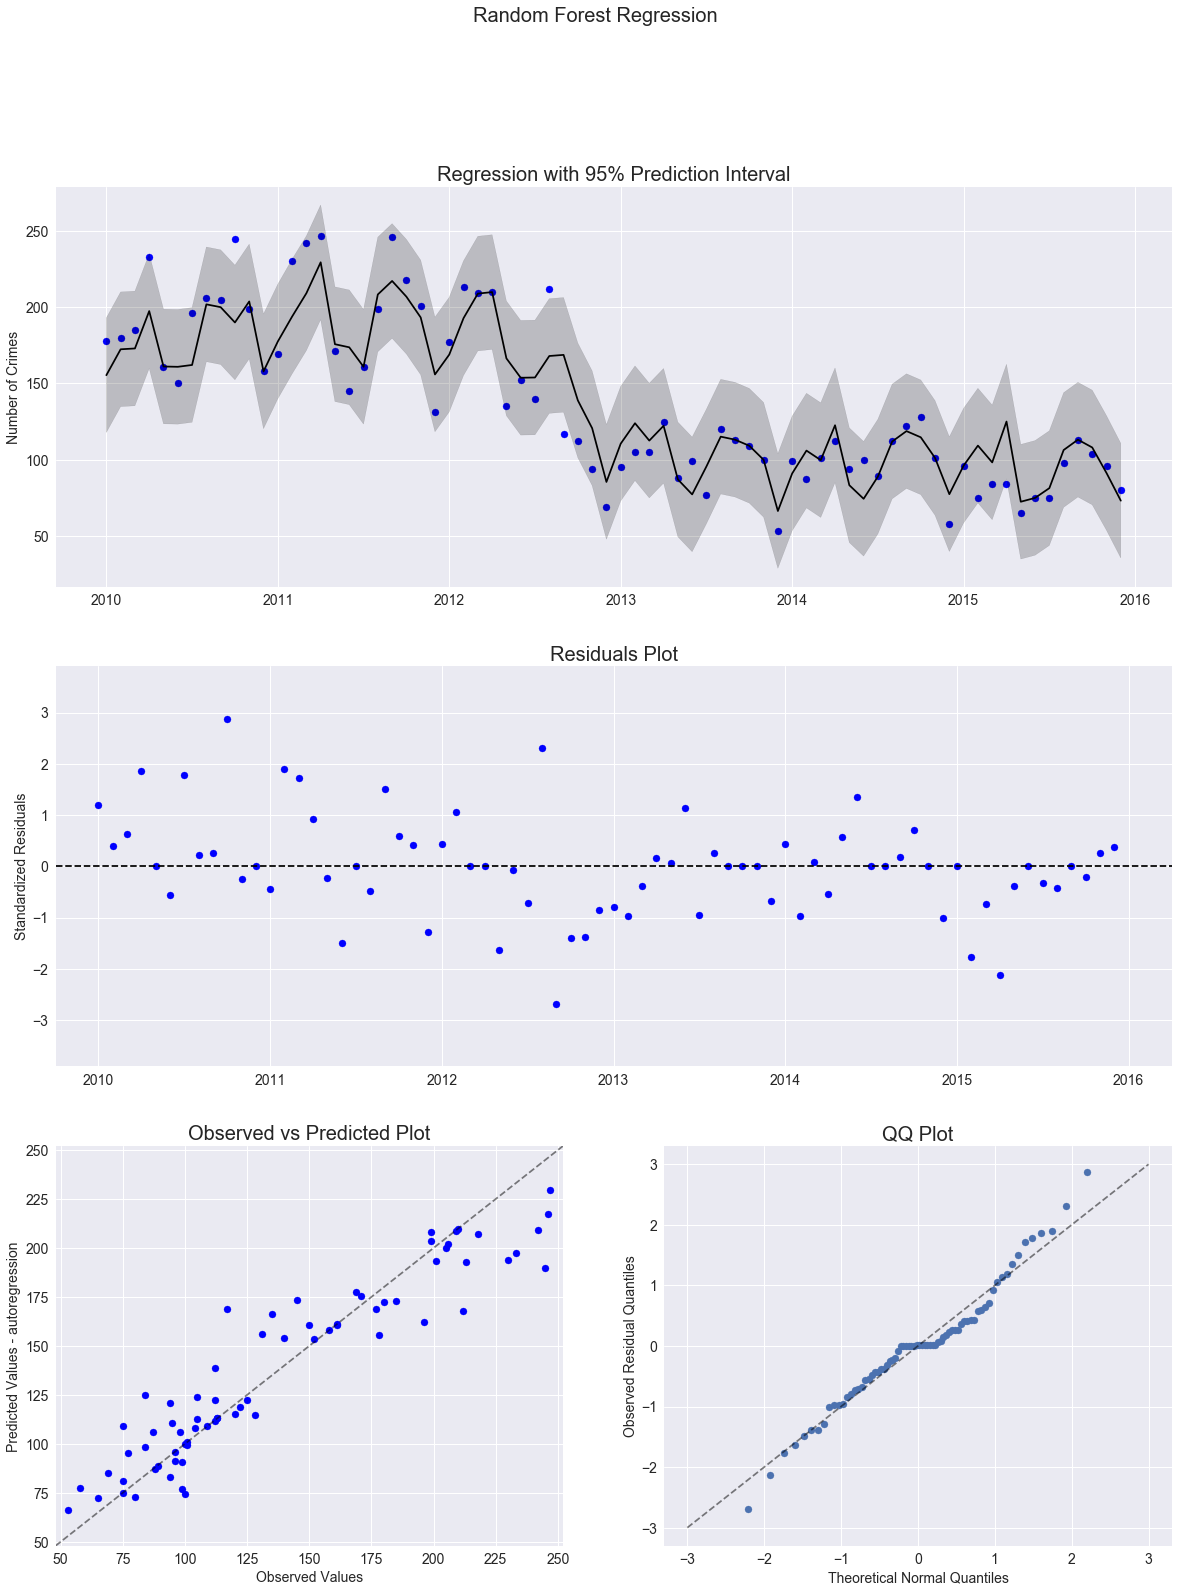

In [19]:
#training random forest regression
steps_rf = [('imputation', imp), ('scale', scale),
            ('rf', RandomForestRegressor(n_estimators=100))]
pipeline_rf = Pipeline(steps_rf)
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_svr, len(X_train[0]))
plot_summary(y_train, y_pred_svr, 'Random Forest Regression', intervals=True);

MSE: 367.9939
RMSE: 19.1832
R-squared: 0.8740
Adjusted R-squared: 0.8211


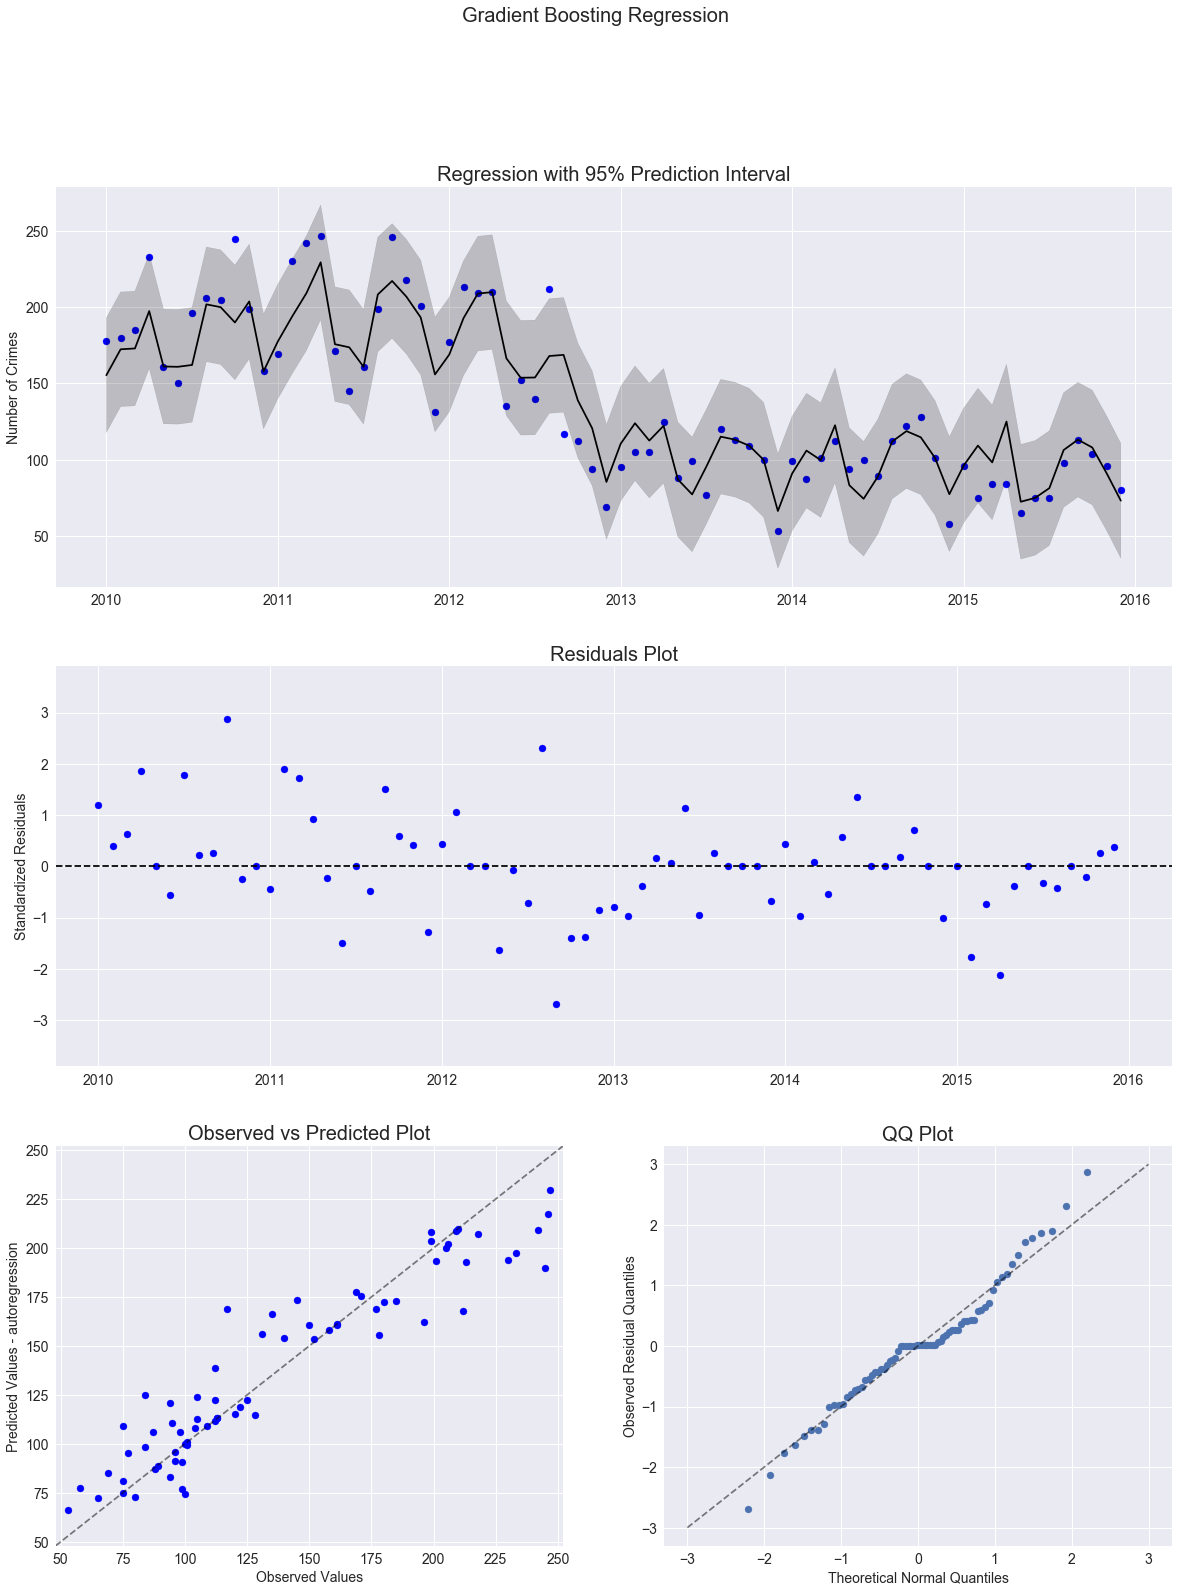

In [20]:
#training gradient boosting regression
steps_gb = [('imputation', imp), ('scale', scale), ('gb', GradientBoostingRegressor())]
pipeline_gb = Pipeline(steps_gb)
pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_svr, len(X_train[0]))
plot_summary(y_train, y_pred_svr, 'Gradient Boosting Regression', intervals=True);

In [21]:
def calc_fold_mse(pipeline, X, y, params):
    train_size = 32
    sample_size = len(y)
    errors = np.zeros(sample_size-train_size)
    y_pred = np.zeros(sample_size-train_size)
    i = 0
    pipeline.set_params(**params)
    while train_size < sample_size:       
        pipeline.fit(X[:train_size], y[:train_size])
        y_pred[i] = pipeline.predict(X[train_size].reshape(1, -1))
        errors[i] = y[train_size] - y_pred[i]
        train_size += 1
        i += 1
    mse = np.square(errors).sum()/len(errors)
    #print(mse)
    return mse

def grid_search_cv(pipeline, X, y, param_names, param_vals):
    best_mse = np.inf
    best_params = None
    for comb in itertools.product(*param_vals):
        params = {name:val for name, val in zip(param_names, comb)}
        #print(params)
        mse = calc_fold_mse(pipeline, X, y, params)
        if mse < best_mse:
            best_mse = mse
            best_param = params
    return best_mse, best_param

In [23]:
#a, b = grid_search_cv(pipeline_en, X_train, y_train,
#                      param_names=['regression__alpha'],
#                      param_vals=[np.logspace(-2, 10, 13, base=2)])
#print(np.sqrt(a), b)
#fig, ax = plt.subplots(figsize=(20,10))
#plt.plot(y_pred)
#plt.plot(y_pred_lr, color='red')
#plt.plot(y_train[36:], ls='', marker='.', markersize=20)
#plt.xticks(range(0, 32))
#ax.set_xticklabels(range(1, 33))
#plt.show()

#print(a, b)

In [24]:
#a, b = grid_search_cv(pipeline_svr, X_train, y_train, 
#                      param_names=['regression__C', 'regression__epsilon'],
                      #param_vals=[np.logspace(-5, 5, 11, base=2), np.logspace(-5, 5, 11, base=2)])
#print(np.sqrt(a), b)

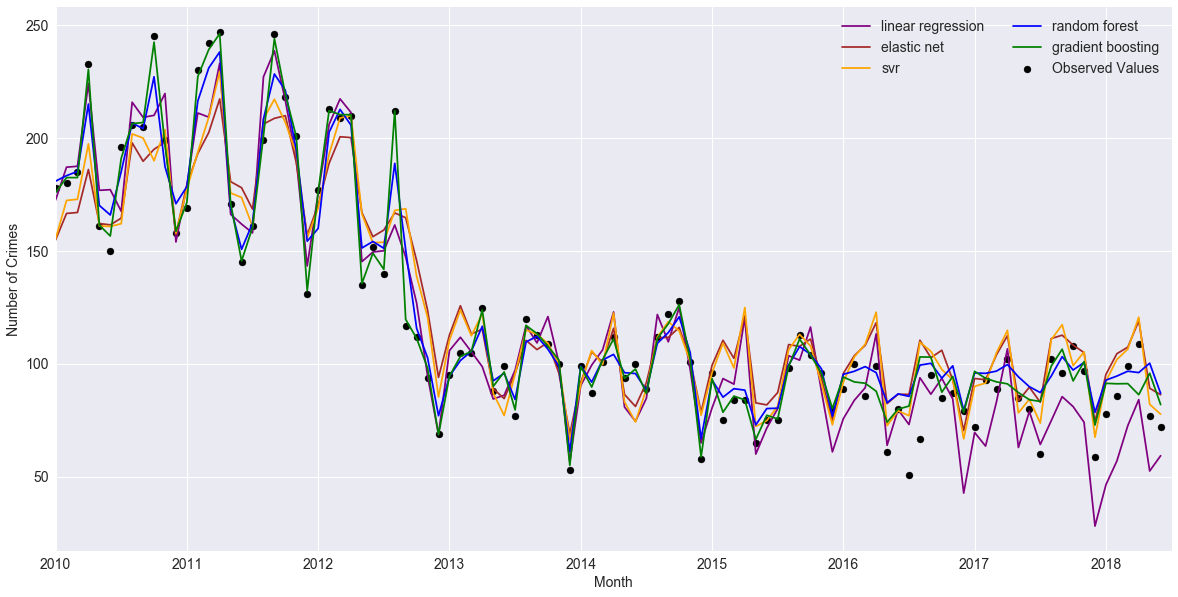

In [28]:
plt.figure(figsize=(20, 10))

plt.scatter(x = range(len(y)), y = y, color='k')
plt.plot(pipeline_lr.predict(X), color='purple')
plt.plot(pipeline_en.predict(X), color='brown')
plt.plot(pipeline_svr.predict(X), color='orange')
plt.plot(pipeline_rf.predict(X), color='b')
plt.plot(pipeline_gb.predict(X), color='g')
#plt.plot(range(len(y_train), len(y)), y_pred_ar, color='r', alpha=0.4)


#plt.axvspan(-1, 72, color='g', alpha=0.1)
#plt.axvspan(72, 100, color='r', alpha=0.1)
plt.xlim(0, len(y))
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, len(y_train)+len(y_test), 12), range(2010, 2019))
plt.legend(['linear regression', 'elastic net', 'svr', 'random forest', 'gradient boosting', 'Observed Values'], ncol=2)
plt.show()

Lag: 11
MSE of test data: 459.1896676842944


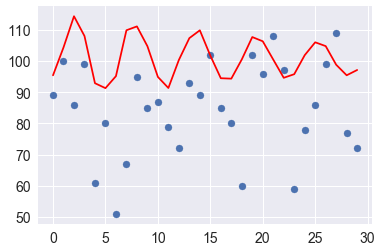

In [29]:
#training autoregression
model = AR(y_train)
model_fit = model.fit()
lag = model_fit.k_ar
print('Lag: {}'.format(lag))

#making predictions
y_pred_ar = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
#for i, prediction in enumerate(y_pred_ar):
#    print('predicted={}, expected={}'.format(prediction, y_test[i]))
mse_ar = mean_squared_error(y_test, y_pred_ar)
print('MSE of test data: {}'.format(mse_ar))

#plotting results
plt.scatter(x=range(len(y_test)), y=y_test)
plt.plot(y_pred_ar, color='red')
plt.show()

predicted=95.435877, expected=89.000000
predicted=101.454358, expected=100.000000
predicted=110.456724, expected=86.000000
predicted=95.293641, expected=99.000000
predicted=80.913939, expected=61.000000
predicted=77.497782, expected=80.000000
predicted=78.430483, expected=51.000000
predicted=79.950616, expected=67.000000
predicted=73.879161, expected=95.000000
predicted=78.474573, expected=85.000000
predicted=88.193494, expected=87.000000
predicted=63.695583, expected=79.000000
predicted=80.030474, expected=72.000000
predicted=80.752940, expected=93.000000
predicted=96.298363, expected=89.000000
predicted=101.800814, expected=102.000000
predicted=84.837625, expected=85.000000
predicted=85.281414, expected=80.000000
predicted=83.139796, expected=60.000000
predicted=77.722207, expected=102.000000
predicted=100.705885, expected=96.000000
predicted=101.078325, expected=108.000000
predicted=92.299608, expected=97.000000
predicted=81.530004, expected=59.000000
predicted=77.566968, expected=7

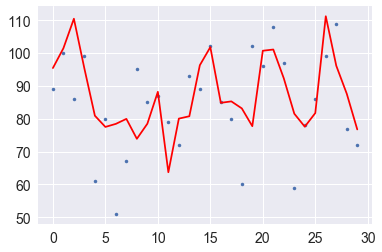

In [30]:
train = y_train
test = y_test

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = list(train[len(train)-window:])
predictions = []
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test, linestyle='', marker='.')
pyplot.plot(predictions, color='red')
pyplot.show()

In [31]:
f.loc[(slice(2010, 2018), 12), ['num_crimes'] + cols]

NameError: name 'cols' is not defined